# 导入数据

In [2]:
import pandas as pd #导入Pandas
df_sales = pd.read_csv('易速鲜花订单记录.csv') #载入数据
df_sales.head() #显示头几行数据 

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市
0,536374,21258,6/1/2020 9:09,五彩玫瑰五支装,32,10.95,15100,北京
1,536376,22114,6/1/2020 9:32,茉莉花白色25枝,48,3.45,15291,上海
2,536376,21733,6/1/2020 9:32,教师节向日葵3枝尤加利5枝,64,2.55,15291,上海
3,536378,22386,6/1/2020 9:37,百合粉色10花苞,10,1.95,14688,北京
4,536378,85099C,6/1/2020 9:37,橙黄香槟色康乃馨,10,1.95,14688,北京


# 数据可视化

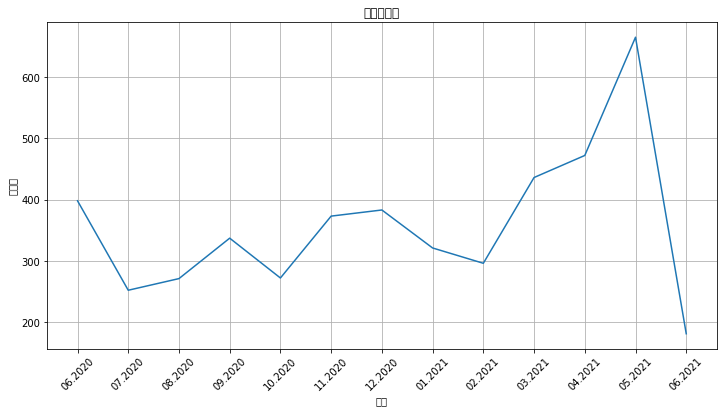

In [4]:
import matplotlib.pyplot as plt #导入Matplotlib的pyplot模块
#构建月度的订单数的DataFrame
df_sales['消费日期'] = pd.to_datetime(df_sales['消费日期']) #转化日期格式
df_orders_monthly = df_sales.set_index('消费日期')['订单号'].resample('M').nunique()
#设定绘图的画布
ax = pd.DataFrame(df_orders_monthly.values).plot(grid=True,figsize=(12,6),legend=False)
ax.set_xlabel('月份') # X轴label
ax.set_ylabel('订单数') # Y轴Label
ax.set_title('月度订单数') # 图题
#设定X轴月份显示格式
plt.xticks(
    range(len(df_orders_monthly.index)), 
    [x.strftime('%m.%Y') for x in df_orders_monthly.index], 
    rotation=45)
plt.show() # 绘图

# 数据清洗

In [5]:
df_sales = df_sales.drop_duplicates() #删除重复的数据行

In [6]:
df_sales.isna().sum() # NaN出现的次数

订单号     0
产品码     0
消费日期    0
产品说明    0
数量      0
单价      0
用户码     0
城市      0
dtype: int64

In [7]:
df_sales.describe() #df_sales的统计信息

,数量,单价,用户码
count,85920.000000,85920.000000,85920.000000
mean,10.115747,3.599711,15338.080389
std,49.114285,134.410498,391.309086
min,-9360.000000,0.000000,14681.000000
25%,2.000000,1.250000,15022.000000
50%,4.000000,1.950000,15334.000000
75%,12.000000,3.750000,15673.000000
max,3114.000000,38970.000000,16019.000000


In [8]:
df_sales = df_sales.loc[df_sales['数量'] > 0] #清洗掉数量小于等于0的数据

In [9]:
df_sales.describe() #df_sales的统计信息

,数量,单价,用户码
count,84112.000000,84112.000000,84112.000000
mean,10.760236,3.005032,15337.732963
std,34.018906,15.365085,392.074855
min,1.000000,0.000000,14681.000000
25%,2.000000,1.250000,15021.000000
50%,5.000000,1.950000,15333.000000
75%,12.000000,3.750000,15674.000000
max,3114.000000,3155.950000,16019.000000


# 特征工程

In [10]:
df_sales['总价'] = df_sales['数量'] * df_sales['单价'] #计算每单的总价
df_sales.head() #显示头几行数据  

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市,总价
0,536374,21258,2020-06-01 09:09:00,五彩玫瑰五支装,32,10.95,15100,北京,350.4
1,536376,22114,2020-06-01 09:32:00,茉莉花白色25枝,48,3.45,15291,上海,165.6
2,536376,21733,2020-06-01 09:32:00,教师节向日葵3枝尤加利5枝,64,2.55,15291,上海,163.2
3,536378,22386,2020-06-01 09:37:00,百合粉色10花苞,10,1.95,14688,北京,19.5
4,536378,85099C,2020-06-01 09:37:00,橙黄香槟色康乃馨,10,1.95,14688,北京,19.5


# 构建User用户表

In [11]:
df_user = pd.DataFrame(df_sales['用户码'].unique()) #生成以用户码为主键的结构df_user
df_user.columns = ['用户码'] #设定字段名
df_user = df_user.sort_values(by='用户码',ascending=True).reset_index(drop=True) #按用户码排序
df_user #显示df_user

,用户码
0,14681
1,14682
2,14684
3,14687
4,14688
...,...
975,16015
976,16016
977,16017
978,16018


# 求R值: 新进度，代表自用户上次消费以来的天数

In [12]:
df_sales['消费日期'] = pd.to_datetime(df_sales['消费日期']) #转化日期格式
df_recent_buy = df_sales.groupby('用户码').消费日期.max().reset_index() #构建消费日期信息
df_recent_buy.columns = ['用户码','最近日期'] #设定字段名
df_recent_buy['R值'] = (df_recent_buy['最近日期'].max() - df_recent_buy['最近日期']).dt.days #计算最新日期与上次消费日期的天数
df_user = pd.merge(df_user, df_recent_buy[['用户码','R值']], on='用户码') #把上次消费距最新日期的天数（R值）合并至df_user结构
df_user.head() #显示df_user头几行数据

,用户码,R值
0,14681,70
1,14682,187
2,14684,25
3,14687,106
4,14688,7


# 求F值: 消费频率，代表用户是否频繁使用服务

In [13]:
df_frequency = df_sales.groupby('用户码').消费日期.count().reset_index() #计算每个用户消费次数，构建df_frequency对象
df_frequency.columns = ['用户码','F值'] #设定字段名称
df_user = pd.merge(df_user, df_frequency, on='用户码') #把消费频率整合至df_user结构
df_user.head() #显示头几行数据

,用户码,R值,F值
0,14681,70,7
1,14682,187,2
2,14684,25,390
3,14687,106,15
4,14688,7,324


# 求M值: 消费金额，代表用户在一段时间内消费的总金额

In [14]:
df_revenue = df_sales.groupby('用户码').总价.sum().reset_index() #根据消费总额，构建df_revenue对象
df_revenue.columns = ['用户码','M值'] #设定字段名称
df_user = pd.merge(df_user, df_revenue, on='用户码') #把消费金额整合至df_user结构
df_user.head() #显示头几行数据

,用户码,R值,F值,M值
0,14681,70,7,498.95
1,14682,187,2,52.00
2,14684,25,390,1201.51
3,14687,106,15,628.38
4,14688,7,324,5579.10


# 显示R、F、M值的分布情况

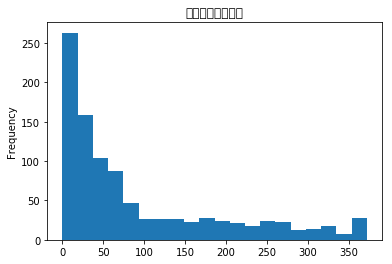

In [15]:
df_user['R值'].plot(kind='hist', bins=20, title = '新进度分布直方图') #R值直方图

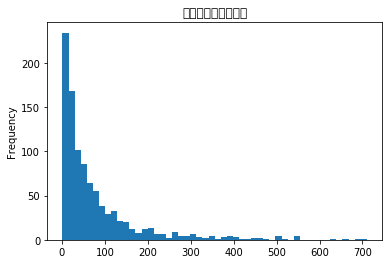

In [16]:
df_user.query('F值 < 800')['F值'].plot(kind='hist', bins=50, title = '消费频率分布直方图') #F值直方图

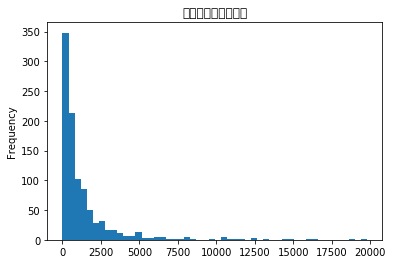

In [17]:
df_user.query('M值 < 20000')['M值'].plot(kind='hist', bins=50, title = '消费金额分布直方图') #M值直方图

# 显示手肘图辅助确定K值

## 手肘法是通过聚类算法的损失值曲线来直观确定簇的数量

## 损失值曲线，就是以图像的方法绘出，取每一个 K 值时，各个数据点距离质心的平均距离

In [25]:
from sklearn.cluster import KMeans #导入KMeans模块
def show_elbow(df): #定义手肘函数
    distance_list = [] #聚质心的距离（损失）
    K = range(1,9) #K值范围
    for k in K:
        kmeans = KMeans(n_clusters=k, max_iter=100) #创建KMeans模型
        kmeans = kmeans.fit(df) #拟合模型
        distance_list.append(kmeans.inertia_) #创建每个K值的损失
    plt.plot(K, distance_list, 'bx-') #绘图
    plt.xlabel('k') #X轴
    plt.ylabel('距离均方误差') #Y轴
    plt.title('k值手肘图') #标题

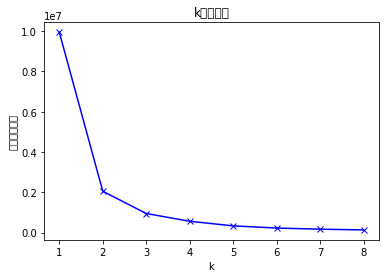

In [20]:
show_elbow(df_user[['R值']]) #显示R值聚类K值手肘图

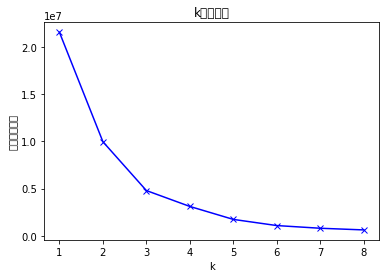

In [26]:
show_elbow(df_user[['F值']]) #显示F值聚类K值手肘图

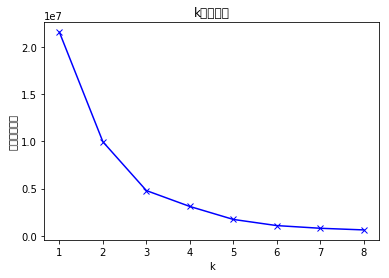

In [27]:
show_elbow(df_user[['F值']]) #显示F值聚类K值手肘图

# 创建和训练模型

In [28]:
from sklearn.cluster import KMeans #导入KMeans模块
kmeans_R = KMeans(n_clusters=3) #设定K=3
kmeans_F = KMeans(n_clusters=4) #设定K=4
kmeans_M = KMeans(n_clusters=4) #设定K=4

In [29]:
kmeans_R.fit(df_user[['R值']]) #拟合模型
kmeans_F.fit(df_user[['F值']]) #拟合模型
kmeans_M.fit(df_user[['M值']]) #拟合模型

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

# 给R值聚类

In [31]:
df_user['R值层级'] = kmeans_R.predict(df_user[['R值']]) #通过聚类模型求出R值的层级
df_user.head() #显示头几行数据

,用户码,R值,F值,M值,R值层级
0,14681,70,7,498.95,1
1,14682,187,2,52.00,2
2,14684,25,390,1201.51,1
3,14687,106,15,628.38,2
4,14688,7,324,5579.10,1


In [32]:
df_user.groupby('R值层级')['R值'].describe() #R值层级分组统计信息

,count,mean,std,min,25%,50%,75%,max
R值层级,,,,,,,,
0,138.0,298.094203,45.436550,231.0,255.25,292.5,334.50,372.0
1,664.0,32.088855,25.141763,0.0,10.00,25.0,50.00,94.0
2,178.0,157.162921,37.340870,95.0,126.00,156.5,188.75,225.0


# 给聚类后的层级排序

In [33]:
#定义一个order_cluster函数为聚类排序
def order_cluster(cluster_name, target_name,df,ascending=False):
    new_cluster_name = 'new_' + cluster_name #新的聚类名称
    df_new = df.groupby(cluster_name)[target_name].mean().reset_index() #按聚类结果分组，创建df_new对象
    df_new = df_new.sort_values(by=target_name,ascending=ascending).reset_index(drop=True) #排序
    df_new['index'] = df_new.index #创建索引字段
    df_new = pd.merge(df,df_new[[cluster_name,'index']], on=cluster_name) #基于聚类名称把df_new还原为df对象，并添加索引字段
    df_new = df_new.drop([cluster_name],axis=1) #删除聚类名称
    df_new = df_new.rename(columns={"index":cluster_name}) #将索引字段重命名为聚类名称字段
    return df_new #返回排序后的df_new对象

In [34]:
df_user = order_cluster('R值层级', 'R值', df_user, False) #调用簇排序函数
df_user = df_user.sort_values(by='用户码',ascending=True).reset_index(drop=True) #根据用户码排序
df_user.head() #显示头几行数据

,用户码,R值,F值,M值,R值层级
0,14681,70,7,498.95,2
1,14682,187,2,52.00,1
2,14684,25,390,1201.51,2
3,14687,106,15,628.38,1
4,14688,7,324,5579.10,2


In [35]:
df_user.groupby('R值层级')['R值'].describe() #R值层级分组统计信息

,count,mean,std,min,25%,50%,75%,max
R值层级,,,,,,,,
0,138.0,298.094203,45.436550,231.0,255.25,292.5,334.50,372.0
1,178.0,157.162921,37.340870,95.0,126.00,156.5,188.75,225.0
2,664.0,32.088855,25.141763,0.0,10.00,25.0,50.00,94.0


# 继续给F、M值聚类，并排序

In [36]:
df_user['F值层级'] = kmeans_F.predict(df_user[['F值']]) #通过聚类模型求出F值的层级
df_user = order_cluster('F值层级', 'F值',df_user,True) #调用簇排序函数
df_user.groupby('F值层级')['F值'].describe() #F值层级分组统计信息

,count,mean,std,min,25%,50%,75%,max
F值层级,,,,,,,,
0,720.0,32.277778,24.128263,1.0,12.00,27.0,48.25,92.0
1,203.0,152.960591,50.338738,93.0,113.50,138.0,191.50,279.0
2,50.0,417.080000,109.618232,289.0,329.75,390.0,492.50,710.0
3,7.0,1281.000000,515.121345,887.0,996.50,1112.0,1304.50,2366.0


In [37]:
df_user = df_user.sort_values(by='用户码',ascending=True).reset_index(drop=True) #根据用户码排序
df_user.head()

,用户码,R值,F值,M值,R值层级,F值层级
0,14681,70,7,498.95,2,0
1,14682,187,2,52.00,1,0
2,14684,25,390,1201.51,2,2
3,14687,106,15,628.38,1,0
4,14688,7,324,5579.10,2,2


In [38]:
df_user['M值层级'] = kmeans_M.predict(df_user[['M值']]) #通过聚类模型求出M值的层级
df_user = order_cluster('M值层级', 'M值',df_user,True) #调用簇排序函数
df_user.groupby('M值层级')['M值'].describe() #M值层级分组统计信息
df_user = df_user.sort_values(by='用户码',ascending=True).reset_index(drop=True) #根据用户码排序
df_user.head() #显示头几行数据

,用户码,R值,F值,M值,R值层级,F值层级,M值层级
0,14681,70,7,498.95,2,0,0
1,14682,187,2,52.00,1,0,0
2,14684,25,390,1201.51,2,2,0
3,14687,106,15,628.38,1,0,0
4,14688,7,324,5579.10,2,2,1


# 为用户整体分组画像

In [39]:
df_user['总分'] = df_user['R值层级'] + df_user['F值层级'] + df_user['M值层级'] #求出每个用户RFM总分

In [40]:
#在df_user对象中添加总体价值这个字段
df_user.loc[(df_user['总分']<=2) & (df_user['总分']>=0), '总体价值'] = '低价值' 
df_user.loc[(df_user['总分']<=4) & (df_user['总分']>=3), '总体价值'] = '中价值' 
df_user.loc[(df_user['总分']<=8) & (df_user['总分']>=5), '总体价值'] = '高价值'
df_user #显示df_user

,用户码,R值,F值,M值,R值层级,F值层级,M值层级,总分,总体价值
0,14681,70,7,498.95,2,0,0,2,低价值
1,14682,187,2,52.00,1,0,0,1,低价值
2,14684,25,390,1201.51,2,2,0,4,中价值
3,14687,106,15,628.38,1,0,0,1,低价值
4,14688,7,324,5579.10,2,2,1,5,高价值
...,...,...,...,...,...,...,...,...,...
975,16015,3,181,704.55,2,1,0,3,中价值
976,16016,2,224,1465.51,2,1,0,3,中价值
977,16017,46,32,211.88,2,0,0,2,低价值
978,16018,38,28,408.90,2,0,0,2,低价值


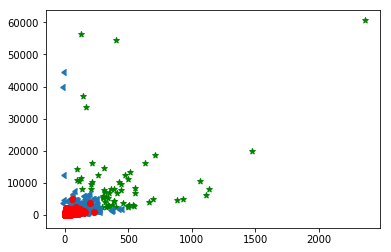

In [41]:
#显示高、中、低价值组分布散点图（F值与M值）
plt.scatter(df_user.query("总体价值 == '高价值'")['F值'],
                   df_user.query("总体价值 == '高价值'")['M值'],c='g',marker='*')
plt.scatter(df_user.query("总体价值 == '中价值'")['F值'],
                   df_user.query("总体价值 == '中价值'")['M值'],marker=8)
plt.scatter(df_user.query("总体价值 == '低价值'")['F值'],
                   df_user.query("总体价值 == '低价值'")['M值'],c='r')